In [42]:
import numpy as np
import pandas as pd
import uproot3 as uproot
import matplotlib.pyplot as plt 

from scipy.optimize import curve_fit
from scipy.special import factorial

import os

import sqlite3

def loadFiles( tfile, treename, selbranches = ["event", "ch", "amp", "area", "time"], flatenndf=True ):
    ttree = uproot.open(tfile)
    data = ttree[treename].arrays(branches=selbranches, outputtype=pd.DataFrame, flatten=flatenndf)
    
    return data

def posson_fit(k, lamb):
    '''poisson function, parameter lamb is the fit parameter'''
    return (lamb**k/factorial(k)) * np.exp(-lamb)


def countevents( x, thr ):
    
    a = np.array(x)
    counts = len( a[a>thr] )
    
    return counts


In [51]:
FILENAMES=["../histograms/"+file for file in os.listdir("../histograms/")]

for FILENAME in FILENAMES:
    
    print(FILENAME)
    
    ophit = loadFiles( FILENAME, "simpleLightAna/ophit_ttree", selbranches = ["event", "channel_id", "amplitude", "integral", "start_time"] )
    data = ophit.groupby(["channel_id", "event"]).amplitude.agg(list)
    data = data.reset_index()

    data['counts16'] = data['amplitude'].apply( lambda x : countevents(x, 16) ) # 16 adc = 1.9 mV
    
    rates = []
    erates = []
    
    for ch in range(360):
    
        weights, edges = np.histogram( data[data.channel_id==ch].counts16, range=(0, 10), bins=10, density=True)
        centers = [ ( edges[i]+edges[i-1] ) / 2.0 for i in range( 1, len(edges) )  ]
    
        try:
            parameters, cov_matrix = curve_fit(posson_fit, centers, weights, p0=[2])
            #print(ch, parameters, cov_matrix)
            rates.append( parameters[0] )
            erates.append(cov_matrix[0]**2)
        except:
            #print(ch)
            rates.append(-9999)
            erates.append(-9999)
    
    
    # Now we extract the timestamp, the run and the readout size from the file and put everything in a database
    try:
        ttree = uproot.open(FILENAME)
        nticks = ttree["simpleLightAna/daqPMTwfttree"]["nticks"].array(entrystop=1)[0]
        run = ttree["simpleLightAna/eventstree"]["run"].array(entrystop=1)[0]
        timestamp = ttree["simpleLightAna/eventstree"]["timestamp"].array(entrystop=1)[0]
    except:
        print("Impossible to create dataframe")
        continue
    
    df = pd.DataFrame( { "channel_id" : np.arange(360), "counts" : rates, "ecounts" : erates ,"readout" : nticks*2.0, "run" : run, "timestamp" : timestamp } )
    
    outfilename = ( FILENAME.replace("histograms", "rates") ).replace("pulseDistributionHist", "rate_analysis")
    df.to_csv( outfilename, sep=',', index=False )

../histograms/pulseDistributionHist_run6069.root


/tmp/ipykernel_18345/3089815669.py:21: RuntimeWarning: invalid value encountered in power
  return (lamb**k/factorial(k)) * np.exp(-lamb)
/cvmfs/larsoft.opensciencegrid.org/products/numpy/v1_19_0b/Linux64bit+3.10-2.17-e20-p383b/lib/python3.8/site-packages/numpy-1.19.0-py3.8-linux-x86_64.egg/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


../histograms/pulseDistributionHist_run6232.root
../histograms/pulseDistributionHist_run6101.root
../histograms/pulseDistributionHist_run4734.root
../histograms/pulseDistributionHist_run6372.root
../histograms/pulseDistributionHist_run4887.root
../histograms/pulseDistributionHist_run4886.root
Impossible to create dataframe
../histograms/pulseDistributionHist_run4987.root
../histograms/pulseDistributionHist_run4986.root
../histograms/pulseDistributionHist_run5077.root
../histograms/pulseDistributionHist_run5894.root
../histograms/pulseDistributionHist_run5076.root
../histograms/pulseDistributionHist_run5092.root
../histograms/pulseDistributionHist_run4466.root
../histograms/pulseDistributionHist_run5093.root
../histograms/pulseDistributionHist_run5125.root
../histograms/pulseDistributionHist_run5126.root
../histograms/pulseDistributionHist_run6036.root
../histograms/pulseDistributionHist_run6030.root
../histograms/pulseDistributionHist_run6001.root
../histograms/pulseDistributionHist_ru

     readout   counts        rate
350  10000.0  1.03471  103.471026
     readout    counts       rate
350  25000.0  1.467907  58.716261
     readout    counts       rate
350  30000.0  1.683506  56.116866
ALL DONE!


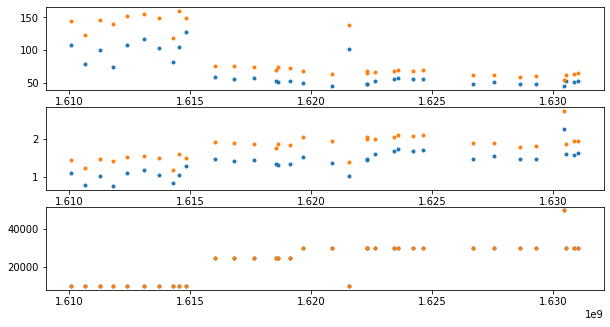

In [74]:
data = pd.concat( [pd.read_csv( "../rates/"+file, sep="," ) for file in os.listdir("../rates/")] )
data = data[data.counts>0]

data['rate'] = data['counts']/(data['readout']*1e-6)
#data['erate'] = data['ecounts']/(data['readout']*1e-6)

print(data[(data.run==4987) & (data.channel_id==350)][['readout', 'counts', 'rate']])
print(data[(data.run==5260) & (data.channel_id==350)][['readout', 'counts', 'rate']])
print(data[(data.run==6030) & (data.channel_id==350)][['readout', 'counts', 'rate']])

fig, ax = plt.subplots(3,1, figsize=(10, 5.2))

for ch in [ 350, 359 ]:
    
    SEL_CH=data.channel_id==ch
    datasel=data[SEL_CH]
    
    ax[0].plot( datasel.timestamp, datasel.rate, '.' )
    ax[1].plot( datasel.timestamp, datasel.counts, '.' )
    ax[2].plot( datasel.timestamp, datasel.readout, '.' )
    
print("ALL DONE!")